# Transfer Learning
Bu örnekte öndecen öğretilmiş bir derin öğrenme modelini kullanarak kedi ve köpek resimlerini öğrenim aktarımı kullarak nasıl sınıflandırıcağımızı göreceğiz.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Veri Hazırlığı

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68608000/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [9]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [ ]:
validation_dataset

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>

['cats', 'dogs']


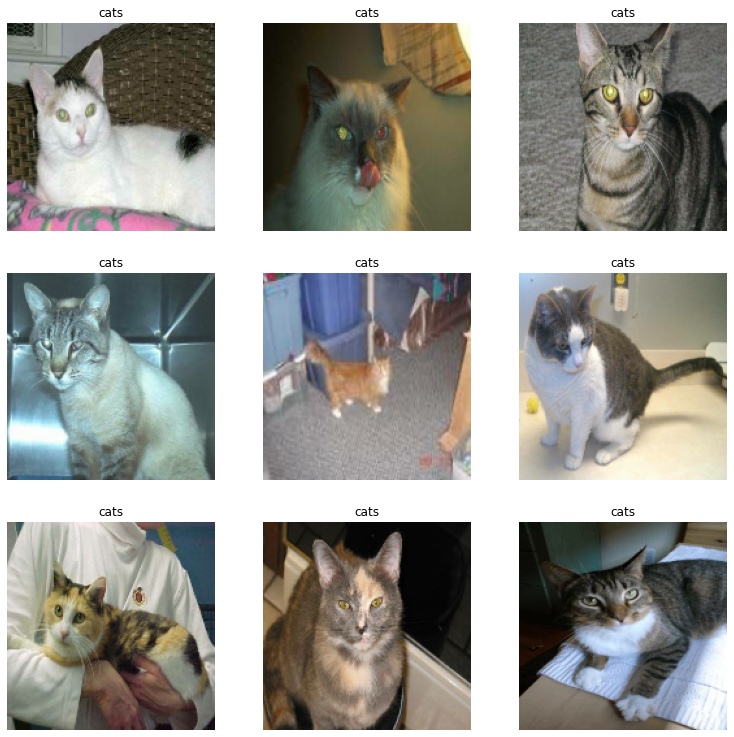

In [4]:
#Train veri setimizi gösterelim
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(13, 13))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
#Test veri setimiz yok, bu yüzden validasyon setindeki batchlerin sayısının %20'sini test olarak ayırıyoruz.
val_batches = tf.data.experimental.cardinality(validation_dataset)
print(f"Batch: {val_batches.numpy()}")
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Batch: 32


In [11]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

Number of validation batches: 26
Number of test batches: 6


In [ ]:
tf.data.experimental.cardinality(test_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=6>

Prefetching, bir eğitim adımının ön işlemesi ve model uygulamasıyla bir arada gitmesini sağlar. Model, `s` eğitim adımını yürütürken, giriş hattı, adım `s + 1` için verileri okur. Bunu yapmak, eğitimin maksimum adım süresini (toplamın aksine) ve verileri çıkarmak için gereken süreyi azaltır. Detaylı bilgi için [dökümantasyona](https://www.tensorflow.org/guide/data_performance) bakabilirsiniz.  
  
tf.data.AUTOTUNE, tf.data çalışma zamanından prefetch değerini çalışma zamanında dinamik olarak ayarlamasını ister.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
#Data Augmentation, şimdi çalışmayacak birazdan modelin içine koyacağız
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

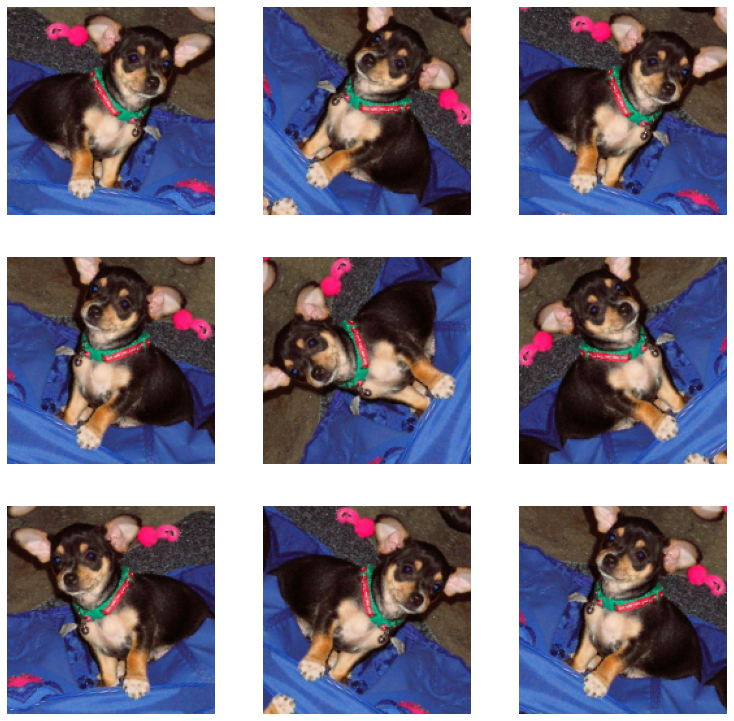

In [16]:
# Çoğaltılmış verileri inceleyelim
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(13, 13))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model

Bu örnekte **MobileNet V2** mimarisini kullanacağız. Bu model, 1.4M görüntü ve 1000 sınıftan oluşan büyük bir veri kümesi olan ImageNet veri kümesi üzerinde önceden eğitilmiştir. Bir çok farklı kategori ile önceden öğretilmesi kedileri ve köpekleri sınıflandırmamıza yardımcı olacaktır.

In [ ]:
# MobileNet V2 [-1,1] aralığındaki pixel değerlerini input olarak alır

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#Alternatif: rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

print(f"Görsel boyutu: {IMG_SIZE}\nGörsel şekli: {IMG_SHAPE}")

9412608/9406464 [==============================] - 0s 0us/step
Görsel boyutu: (160, 160)
Görsel şekli: (160, 160, 3)


In [18]:
#Bu özellik çıkarıcı, her bir "160x160x3" görüntüsünü "5x5x1280" özellik bloğuna dönüştürür. Bir grup resim örneğine ne yaptığını görelim:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [ ]:
#Evrişimli tabanı donduralım. 
#MobileNet V2 birçok katmana sahiptir, bu nedenle tüm modelin eğitilebilirliğini False olarak ayarlamak her katmanı dondurur.
base_model.trainable = False

In [ ]:
#Modelimizin mimarisini inceleyelim
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [20]:
#Özellikler bloğundan tahminler oluşturmak için, özellikleri görüntü başına tek bir 1280 öğeli vektöre dönüştürmek için bir 
#tf.keras.layers.GlobalAveragePooling2D katmanını kullanalım.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
#son olarak bir Dense Layer ekleyerek her görseli tek bir çıktıya çevirelim. Aktivasyon fonksiyonu kullanmamıza gerek yok, çünkü
#pozitif değerler 1 çıktısını, negatif değerler 0 çıktısını ifade edecek.
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
prediction_batch[:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.0054067 ],
       [-0.45831627],
       [-1.2825061 ],
       [-0.18367451],
       [-0.7615221 ]], dtype=float32)>

In [ ]:
# Son modelimizi kuralım
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#Modelimizi compile edelim. İki sınıf olduğundan, model doğrusal bir çıktı sağlar, from_logits = True ile ikili bir BinaryCrossentropy kullanabiliriz.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [ ]:
print(f"Eğitilecek değişken sayısı: {len(model.trainable_variables)}")

Eğitilecek değişken sayısı: 2


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print(f"initial loss: {loss0}")
print(f"initial accuracy: {accuracy0}")

26/26 [==============================] - 3s 37ms/step - loss: 1.1268 - accuracy: 0.4702
initial loss: 1.1729094982147217
initial accuracy: 0.42574256658554077


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 66ms/step - loss: 0.9623 - accuracy: 0.4360 - val_loss: 0.7045 - val_accuracy: 0.5606
Epoch 2/10
63/63 [==============================] - 4s 66ms/step - loss: 0.6772 - accuracy: 0.5965 - val_loss: 0.5093 - val_accuracy: 0.7562
Epoch 3/10
63/63 [==============================] - 4s 66ms/step - loss: 0.5158 - accuracy: 0.7335 - val_loss: 0.3825 - val_accuracy: 0.8403
Epoch 4/10
63/63 [==============================] - 4s 66ms/step - loss: 0.4260 - accuracy: 0.7880 - val_loss: 0.3100 - val_accuracy: 0.8787
Epoch 5/10
63/63 [==============================] - 5s 67ms/step - loss: 0.3749 - accuracy: 0.8190 - val_loss: 0.2595 - val_accuracy: 0.8911
Epoch 6/10
63/63 [==============================] - 4s 67ms/step - loss: 0.3375 - accuracy: 0.8395 - val_loss: 0.2178 - val_accuracy: 0.9146
Epoch 7/10
63/63 [==============================] - 4s 66ms/step - loss: 0.2972 - accuracy: 0.8725 - val_loss: 0.1927 - val_accuracy: 0.9356
Epoch 8/10
63

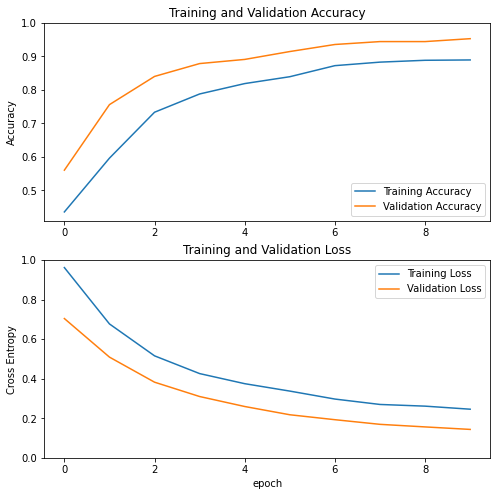

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine-Tuning

**Not:** Bu, yalnızca üst sınıflandırıcı katmanı önceden eğitilmiş, diğer katmanları eğitilemez olarak ayarlanmış şekilde temel modeli eğittikten sonra denenmelidir. Önceden eğitilmiş bir modelin üstüne rastgele başlatılmış bir sınıflandırıcı eklerseniz ve tüm katmanları birlikte eğitmeye çalışırsanız, gradyan güncellemelerinin büyüklüğü çok büyük olur (sınıflandırıcıdan gelen rastgele ağırlıklar nedeniyle) ve önceden eğitilmiş modeliniz öğrendiklerini unutun.

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Temel modeldeki katman sayısı: ", len(base_model.layers))

# Kaç layer tune edilecek?
fine_tune_at = 100

# Önceki tüm katmanları donduralım
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 9s 80ms/step - loss: 0.1733 - accuracy: 0.9132 - val_loss: 0.0746 - val_accuracy: 0.9629
Epoch 11/20
63/63 [==============================] - 5s 71ms/step - loss: 0.1249 - accuracy: 0.9476 - val_loss: 0.0443 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 5s 71ms/step - loss: 0.1008 - accuracy: 0.9630 - val_loss: 0.0444 - val_accuracy: 0.9765
Epoch 13/20
63/63 [==============================] - 5s 70ms/step - loss: 0.1013 - accuracy: 0.9547 - val_loss: 0.0351 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 5s 70ms/step - loss: 0.0947 - accuracy: 0.9623 - val_loss: 0.0598 - val_accuracy: 0.9728
Epoch 15/20
63/63 [==============================] - 5s 71ms/step - loss: 0.0742 - accuracy: 0.9717 - val_loss: 0.0373 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 5s 70ms/step - loss: 0.0880 - accuracy: 0.9668 - val_loss: 0.0369 - val_accuracy: 0.9802
Epoch 

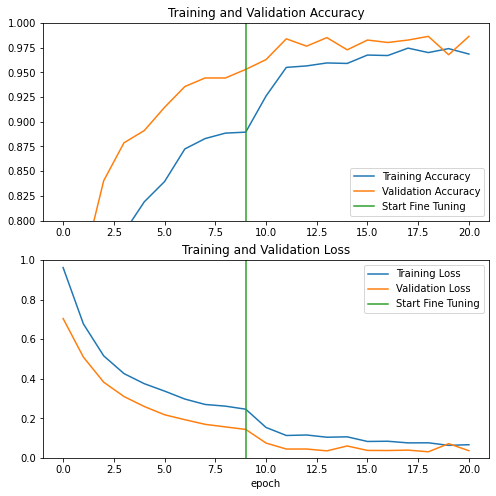

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Tahmin ve Değerlendirme

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 47ms/step - loss: 0.0365 - accuracy: 0.9844
Test accuracy : 0.984375


In [ ]:
tf.nn.sigmoid(predictions1)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([9.9950731e-01, 9.9976283e-01, 3.3033124e-04, 2.4627319e-05,
       9.9975199e-01, 9.9981517e-01, 5.4318050e-05, 5.6223804e-01,
       9.9906641e-01, 5.3868807e-05, 7.4721502e-05, 9.9975711e-01,
       1.1120575e-04, 9.9990642e-01, 9.9568152e-01, 9.9998891e-01,
       6.8732719e-05, 1.8780297e-04, 1.8331816e-04, 9.9997306e-01,
       8.0238831e-05, 9.9987018e-01, 1.1974269e-04, 9.9982113e-01,
       9.9392265e-01, 9.9995339e-01, 1.3849291e-04, 9.9993396e-01,
       9.9950922e-01, 9.4986893e-04, 5.5078242e-05, 6.7125383e-04],
      dtype=float32)>

Predictions:
 [0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1]
Labels:
 [0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1]


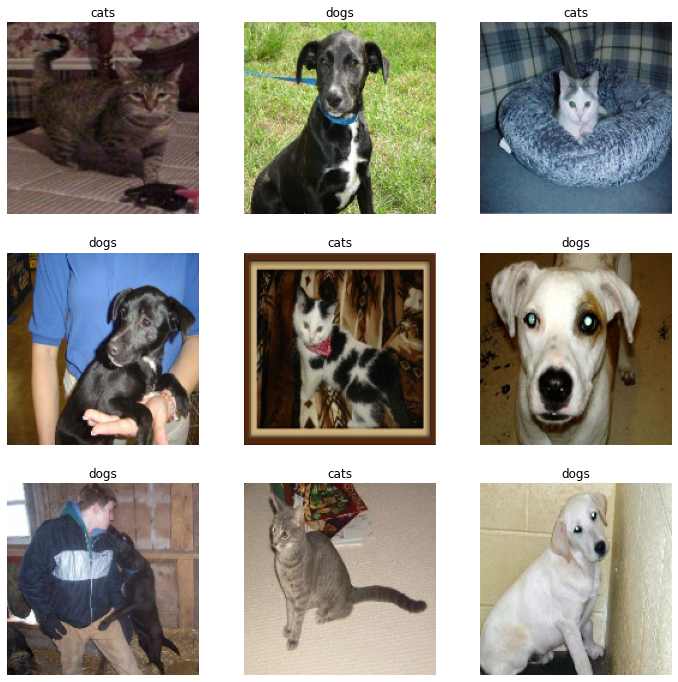

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions1 = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions1)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")